In [11]:
import os

In [12]:
fall_types = ['backward_falls', 'forward_falls', 'left_falls', 'right_falls', 'sitting_falls', 'standing_falls']
non_fall_types =  ['jumping', 'laying', 'picking', 'squat', 'stretching' , 'walking']

In [13]:
def get_images():
    file_paths = []
    # labels = []
    
    train_dir = os.path.join(".", "data", "train")
    subjects = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
    
    for subject in subjects:
        subject_path = os.path.join(train_dir, subject)
        subject_id = subject.split('-')[-1]  # Extract subject ID from folder name
        
        # Fall data
        fall_dir = os.path.join(subject_path, 'fall')
        for fall_type in fall_types:
            fall_type_dir = os.path.join(fall_dir, f"{subject_id}_{fall_type}")
            if os.path.exists(fall_type_dir):
                for file in os.listdir(fall_type_dir):
                    file_paths.append(os.path.join(fall_type_dir, file))
                    # labels.append(1)  # Label 1 for fall
        
        # Non-fall data
        non_fall_dir = os.path.join(subject_path, 'non_fall')
        for non_fall_type in non_fall_types:
            non_fall_type_dir = os.path.join(non_fall_dir, f"{subject_id}_{non_fall_type}")
            if os.path.exists(non_fall_type_dir):
                for file in os.listdir(non_fall_type_dir):
                    file_paths.append(os.path.join(non_fall_type_dir, file))
                    # labels.append(0)  # Label 0 for non-fall

    return file_paths#, labels

In [14]:
images = get_images()

f"There are {len(images)} images in total."

'There are 4294 images in total.'

In [15]:
from ultralytics import YOLO

In [16]:
model = YOLO(os.path.join(".", "weights", "noorkhokhar99", "fall_det_1.pt"))

c:\Users\tsfai\Projects\data-slayer-2.0\venv\Lib\site-packages\ultralytics\nn\tasks.py:714: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(file, map_locatio

In [ ]:
image_paths, labels, confidence_levels = [], [], []

for i, image in enumerate(images):
    image_paths.append(image)
    results = model(image)

    is_fall = int(len(results[0].boxes) > 0)
    labels.append(is_fall)

    if is_fall:
        confidence_levels.append(results[0].boxes[0].conf)
    else:
        confidence_levels.append(0)
        

In [18]:
image_paths[:5], labels[:5], confidence_levels[:5]

(['.\\data\\train\\subject-1\\fall\\1_backward_falls\\frame001.jpg',
  '.\\data\\train\\subject-1\\fall\\1_backward_falls\\frame002.jpg',
  '.\\data\\train\\subject-1\\fall\\1_backward_falls\\frame003.jpg',
  '.\\data\\train\\subject-1\\fall\\1_backward_falls\\frame004.jpg',
  '.\\data\\train\\subject-1\\fall\\1_backward_falls\\frame005.jpg'],
 [0, 0, 1, 1, 0],
 [0, 0, tensor([0.4449]), tensor([0.6165]), 0])

In [21]:
confidence_levels = [float(item) if isinstance(item, (int, float)) else float(item.item()) for item in confidence_levels]

In [10]:
import pandas as pd

In [25]:
data_train = pd.DataFrame({
    'path': image_paths,
    'label': labels,
    'conf': confidence_levels
})

data_train.head()

,path,label,conf
0,.\data\train\subject-1\fall\1_backward_falls\f...,0,0.000000
1,.\data\train\subject-1\fall\1_backward_falls\f...,0,0.000000
2,.\data\train\subject-1\fall\1_backward_falls\f...,1,0.444923
3,.\data\train\subject-1\fall\1_backward_falls\f...,1,0.616470
4,.\data\train\subject-1\fall\1_backward_falls\f...,0,0.000000


In [26]:
data_train.to_csv(os.path.join(".", "data", "data_train.csv"), index=False)

In [18]:
data = pd.read_csv('./data/data_train.csv')
data.head()

,path,label,conf
0,.\data\train\subject-1\fall\1_backward_falls\f...,0,0.000000
1,.\data\train\subject-1\fall\1_backward_falls\f...,0,0.000000
2,.\data\train\subject-1\fall\1_backward_falls\f...,1,0.444923
3,.\data\train\subject-1\fall\1_backward_falls\f...,1,0.616470
4,.\data\train\subject-1\fall\1_backward_falls\f...,0,0.000000


In [64]:
fall_data = data[data['path'].str.contains(r'\\fall\\')]
non_fall_data = data[data['path'].str.contains(r'\\non_fall\\')]

In [26]:
len(fall_data) + len(non_fall_data) == len(data)

True

<Axes: >

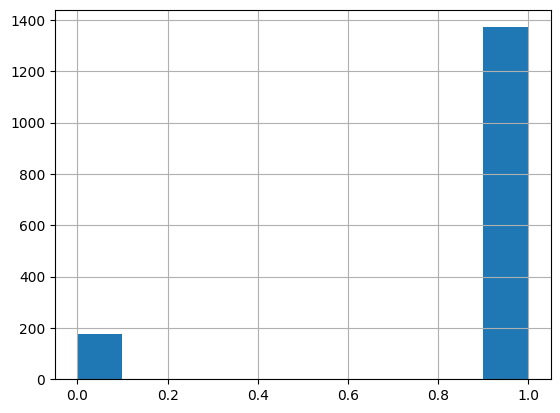

In [27]:
fall_data['label'].hist()

<Axes: >

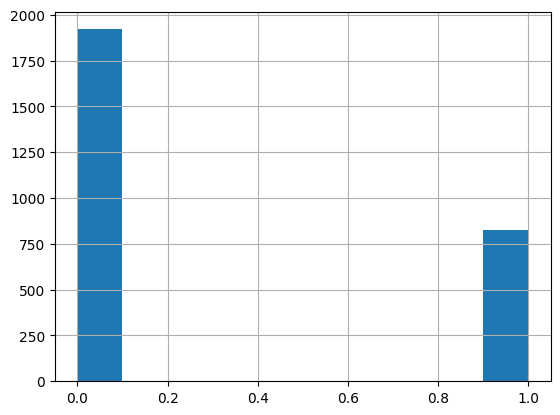

In [29]:
non_fall_data['label'].hist()

In [38]:
from PIL import Image
import matplotlib.pyplot as plt

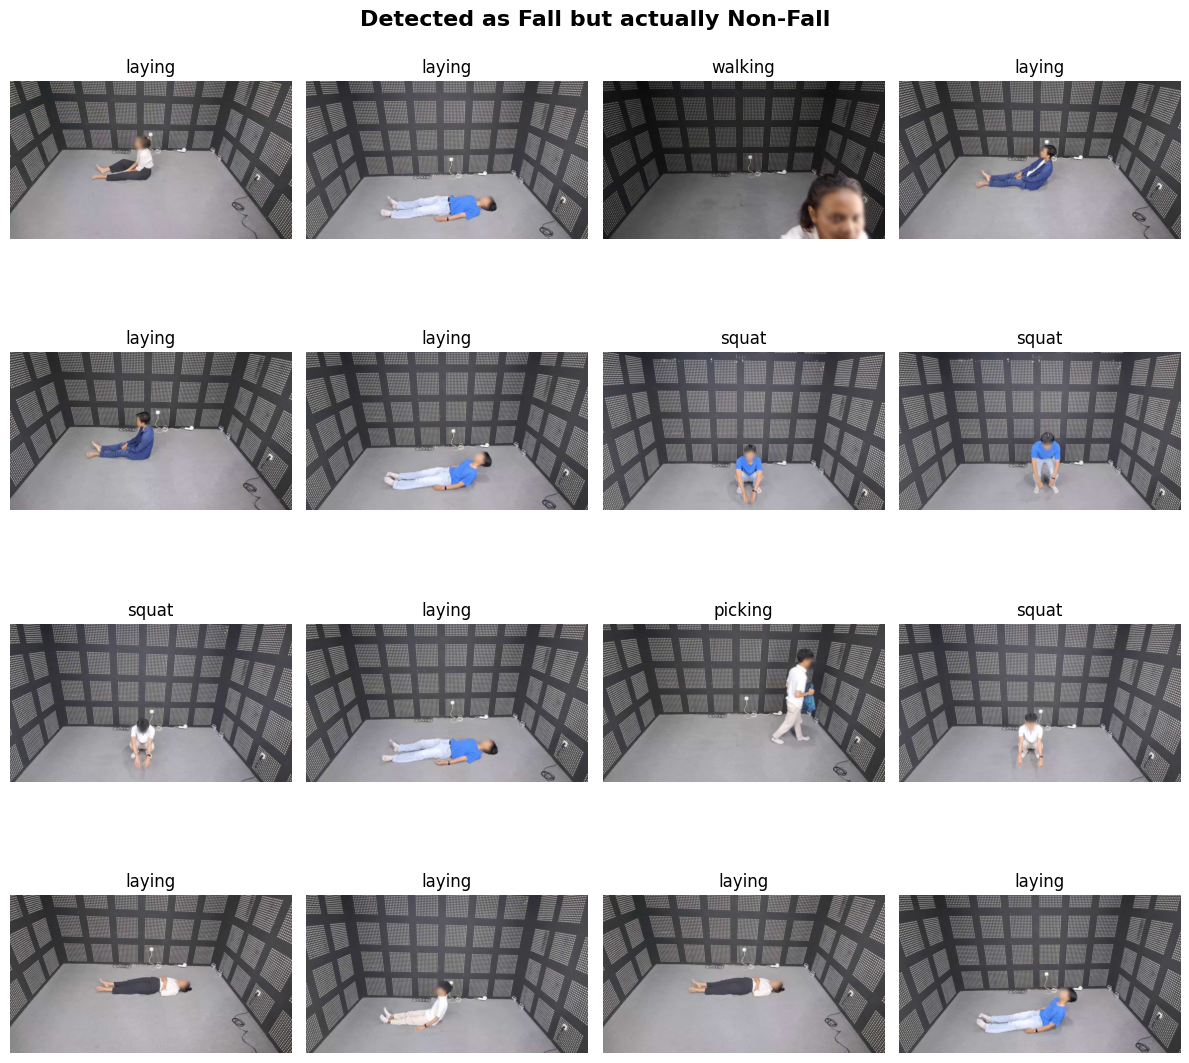

In [61]:
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
false_positive_fall_paths = non_fall_data[non_fall_data['label'] == 1.0].sample(n=16)['path'].values

for ax, file_path in zip(axes.flatten(), false_positive_fall_paths):
    try:
        img = Image.open(file_path)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(file_path.split('\\')[-2][2:])
    except Exception as e:
        ax.set_title("Error")
        ax.axis('off')
        
plt.suptitle("Detected as Fall but actually Non-Fall", fontsize=16, fontweight='bold', y=0.95)
plt.tight_layout()
plt.show()

In [65]:
non_fall_data.loc[non_fall_data['label'] == 1, 'label'] = 0
non_fall_data.loc[non_fall_data['label'] == 1, 'conf'] = 0

In [67]:
non_fall_data['label'].describe()

count    2748.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: label, dtype: float64

In [71]:
data = pd.concat([fall_data, non_fall_data], ignore_index=True)
data.head()

,path,label,conf
0,.\data\train\subject-1\fall\1_backward_falls\f...,0,0.000000
1,.\data\train\subject-1\fall\1_backward_falls\f...,0,0.000000
2,.\data\train\subject-1\fall\1_backward_falls\f...,1,0.444923
3,.\data\train\subject-1\fall\1_backward_falls\f...,1,0.616470
4,.\data\train\subject-1\fall\1_backward_falls\f...,0,0.000000


array([[<Axes: title={'center': 'label'}>, <Axes: title={'center': 'conf'}>]], dtype=object)

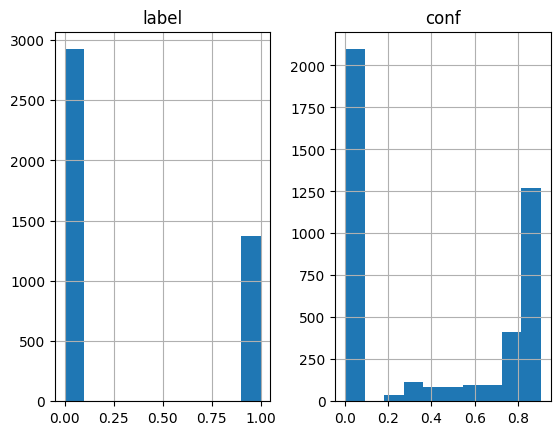

In [76]:
data.hist()

In [77]:
data.to_csv("./data/data_train.csv", index=False)